In [1]:
using Plots
using LabelledArrays
import DifferentialEquations as de
using DifferentialEquations
using Sundials
using DiffEqSensitivity
using ForwardDiff
using LinearAlgebra
using JuMP
using Hypatia

In [4]:
function rate!(dc, c, p, t)
    
    k1 = p[1]
    k2 = p[2]
    k3 = p[3]
    k4 = p[4]
    k5 = p[5]
    
    c_ah = c[1]
    c_b = c[2]
    c_c = c[3]
    c_p = c[4]
    c_am = c[5]
    c_bhp = c[6]
    c_acm = c[7]
    
    r1 = k1 * c_ah * c_b
    r2 = k2 * c_am * c_c
    r3 = k3 * c_acm
    r4 = k4 * c_acm * c_ah
    r5 = k5 * c_acm * c_bhp
    
    dcah_dt = - r1 - r4
    dcb_dt = - r1 + r5
    dcc_dt = - r2 + r3
    dcp_dt = r4 + r5
    dcam_dt = r1 - r2 + r3 + r4
    dcbhp_dt = r1 - r5
    dcacm_dt = r2 - r3 - r4 - r5
    
    dc[1] = dcah_dt
    dc[2] = dcb_dt
    dc[3] = dcc_dt
    dc[4] = dcp_dt
    dc[5] = dcam_dt
    dc[6] = dcbhp_dt
    dc[7] = dcacm_dt
    
end

rate! (generic function with 1 method)

In [6]:
# initial run of the ODE at a specific experimental condition to set up the ODE problem
c0 = [5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0]
p_parms = [49.78, 8.93, 1.32, 0.31, 3.87]
tspan = (0.0, 5.0)
prob = ODEProblem(rate!, c0, tspan, p_parms)
sol = de.solve(prob, Rodas4(), saveat = 0.1)

retcode: Success
Interpolation: 1st order linear
t: 51-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 ⋮
 3.9
 4.0
 4.1
 4.2
 4.3
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
u: 51-element Vector{Vector{Float64}}:
 [5.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0]
 [0.001999015097805973, 2.244187359365918, 1.1215267601370698, 2.242188344268112, 1.119527745039261, 2.7558126406340833, 1.6362848955948235]
 [2.9587668282428945e-9, 3.3270516391640594, 0.6521027037278606, 3.327051636205293, 0.6521027007690905, 1.6729483608359412, 1.0208456600668523]
 [-2.4046582875092292e-12, 3.7974876412981513, 0.4847139529441074, 3.7974876413005556, 0.48471395294650854, 1.2025123587018505, 0.717798405755343]
 [6.608940567829718e-14, 4.056014281627646, 0.3964106880870357, 4.056014281627577, 0.3964106880869661, 0.9439857183723572, 0.5475750302853922]
 [-1.6365324429236182e-14, 4.219138534540339, 0.34076777131959174, 4.219138534540352, 0.3407677713196046, 0.780861465459663, 0.44009369414005

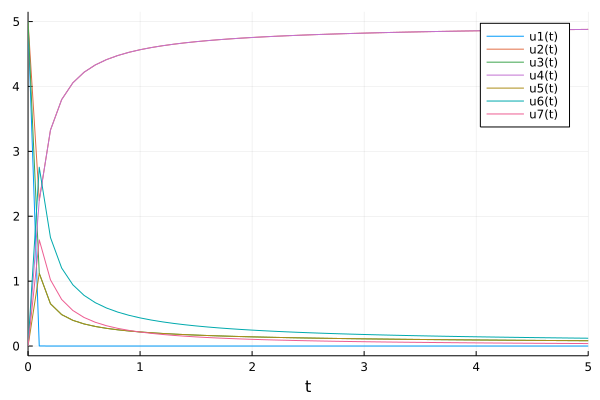

In [8]:
plot(sol)

In [13]:
# ODE problem put into a function so that jacobian could be evaluated with respect to function parameters
function cprofile(p_parms, c0)
    tspan = (0.0, 5.0)
    _prob = remake(prob, u0 = c0, p = p_parms)
    Array(de.solve(_prob, Rodas4(), saveat = 0.1))
end

cprofile (generic function with 2 methods)

In [ ]:
#csol = cprofile(p_parms, [1.0, 0.0], 300.0)
#csens = ForwardDiff.jacobian(p_parms -> cprofile(p_parms, [1.0, 0.0], 300.0), p_parms)

# Note: if there are m responses, k parameters and nT time points, the jacobian is returned as a matrix
# where # nrows = m x nT and # columns = k
# within the rows:
#   response 1 corresponds to rows 1, m+1, 2m+1, ..., m*(nT-1) + 1
#   response 2 corresponds to rows 2, m+2, 2m+2, ..., m*(nT-1) + 2 and so on    

In [11]:
cAH_rng = collect(range(0.1, 5.0, length = 5))
cB_rng = collect(range(1.0, 5.0, length = 5))
cC_rng = collect(range(1.0, 5.0, length = 5))
exp_cond = [[cAH, cB, cC] for cAH in cAH_rng for cB in cB_rng for cC in cC_rng]
t_rng = collect(0:0.1:5.0)

51-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 ⋮
 3.9
 4.0
 4.1
 4.2
 4.3
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0

In [18]:
length(exp_cond)

125

In [19]:
csens_L = []
for (i, e) in enumerate(exp_cond)
    # this command evaluates the jacobian of responses with respect to parameters
    csens = ForwardDiff.jacobian(p_parms -> cprofile(p_parms, [e[1], e[1]*e[2], e[1]*e[3], 0.0, 0.0, 0.0, 0.0]), p_parms)
    push!(csens_L, csens)
    #println(i, e)
end

In [22]:
# Generation of fim from sensitivity results
fim = []
elabel = []
for i in 1:length(exp_cond)
    for j in 1:7:357
        fim_ij = csens_L[i][j:j+1,:]' * csens_L[i][j:j+1,:]
        push!(fim, fim_ij)
        push!(elabel, vcat(exp_cond[i], t_rng[Int((j + 6)/7)]))
    end
end

In [33]:
# Optimization model taken from Hypatia github page. they specifically have D-optimal design as an example
#   https://github.com/chriscoey/Hypatia.jl
#
opt = Hypatia.Optimizer()
model = Model(() -> opt)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Hypatia

In [34]:
nvar = length(fim)
@variable(model, x[1:nvar] >= 0);
@constraint(model, sum(x) == 1);

In [35]:
@variable(model, hypo);
@objective(model, Max, hypo);

In [36]:
Q = sum(x[i] * fim[i] for i in 1:nvar);

In [37]:
aff = vcat(hypo, [Q[i, j] for i in 1:5 for j in 1:i]...);
@constraint(model, aff in MOI.RootDetConeTriangle(5));

In [38]:
optimize!(model)


 iter        p_obj        d_obj |  abs_gap    x_feas    z_feas |      tau       kap        mu | dir_res     prox  step     alpha
    0   6.0126e-01  -1.0031e+00 | 6.38e+03  1.99e-01  1.06e+00 | 1.00e+00  1.00e+00  1.00e+00 |
    1  -2.7897e-01  -8.5488e-01 | 1.91e+03  5.10e-02  2.71e-01 | 1.17e+00  1.06e-01  3.00e-01 | 3.8e-15  9.6e-01  co-a  7.00e-01
    2  -1.1241e-01  -3.8445e-01 | 1.82e+03  2.18e-02  1.16e-01 | 2.61e+00  3.33e-02  2.85e-01 | 6.3e-13  7.5e-01  co-a  5.00e-02
    3  -4.4068e-02  -1.5660e-01 | 1.80e+03  8.80e-03  4.68e-02 | 6.39e+00  1.56e-02  2.82e-01 | 1.1e-13  6.5e-01  co-a  1.00e-02
    4  -2.5553e-02  -8.1270e-02 | 1.71e+03  4.35e-03  2.31e-02 | 1.23e+01  1.32e-02  2.68e-01 | 3.4e-13  4.9e-01  co-a  5.00e-02
    5  -9.4008e-03  -2.8147e-02 | 1.62e+03  1.44e-03  7.67e-03 | 3.52e+01  4.02e-03  2.55e-01 | 2.1e-11  4.4e-01  co-a  5.00e-02
    6  -4.9653e-03  -1.3910e-02 | 1.54e+03  6.89e-04  3.66e-03 | 7.00e+01  4.14e-03  2.42e-01 | 1.1e-11  2.9e-01  co-a  5.00e-02


   63  -3.5237e-04  -4.0454e-04 | 8.18e+01  4.00e-06  2.12e-05 | 6.37e+02  2.01e-05  1.28e-02 | 1.4e-08  2.8e-01  co-a  1.00e-02
   64  -3.5050e-04  -4.0056e-04 | 7.77e+01  3.83e-06  2.04e-05 | 6.31e+02  1.93e-05  1.22e-02 | 2.8e-08  4.3e-01  co-a  5.00e-02
   65  -3.4863e-04  -3.9667e-04 | 7.38e+01  3.68e-06  1.95e-05 | 6.25e+02  1.85e-05  1.16e-02 | 2.1e-08  5.4e-01  co-a  5.00e-02
   66  -3.4671e-04  -3.9284e-04 | 7.01e+01  3.53e-06  1.88e-05 | 6.18e+02  1.78e-05  1.10e-02 | 3.3e-08  6.9e-01  co-a  5.00e-02
   67  -3.4473e-04  -3.8906e-04 | 6.66e+01  3.40e-06  1.80e-05 | 6.11e+02  1.71e-05  1.04e-02 | 6.9e-08  8.8e-01  co-a  5.00e-02
   68  -3.4501e-04  -3.8892e-04 | 6.59e+01  3.36e-06  1.79e-05 | 6.11e+02  1.69e-05  1.03e-02 | 6.7e-08  2.8e-01  co-a  1.00e-02
   69  -3.4312e-04  -3.8530e-04 | 6.26e+01  3.23e-06  1.72e-05 | 6.04e+02  1.63e-05  9.81e-03 | 2.0e-08  4.4e-01  co-a  5.00e-02
   70  -3.4125e-04  -3.8179e-04 | 5.95e+01  3.11e-06  1.65e-05 | 5.97e+02  1.56e-05  9.32e-03 | 2

  127  -2.6786e-04  -2.7634e-04 | 6.13e+00  6.50e-07  3.45e-06 | 2.96e+02  3.24e-06  9.61e-04 | 2.0e-08  4.0e-01  co-a  5.00e-02
  128  -2.6631e-04  -2.7453e-04 | 5.83e+00  6.30e-07  3.35e-06 | 2.91e+02  3.14e-06  9.13e-04 | 4.9e-08  5.9e-01  co-a  5.00e-02
  129  -2.6477e-04  -2.7273e-04 | 5.53e+00  6.11e-07  3.24e-06 | 2.85e+02  3.05e-06  8.67e-04 | 5.6e-08  8.3e-01  co-a  5.00e-02
  130  -2.6468e-04  -2.7258e-04 | 5.48e+00  6.06e-07  3.22e-06 | 2.84e+02  3.02e-06  8.58e-04 | 6.9e-08  3.1e-01  co-a  1.00e-02
  131  -2.6318e-04  -2.7084e-04 | 5.20e+00  5.87e-07  3.12e-06 | 2.79e+02  2.93e-06  8.15e-04 | 1.0e-07  5.2e-01  co-a  5.00e-02
  132  -2.6169e-04  -2.6910e-04 | 4.94e+00  5.68e-07  3.02e-06 | 2.73e+02  2.83e-06  7.74e-04 | 9.9e-08  7.4e-01  co-a  5.00e-02
  133  -2.6159e-04  -2.6894e-04 | 4.89e+00  5.64e-07  3.00e-06 | 2.73e+02  2.81e-06  7.67e-04 | 4.2e-08  2.5e-01  co-a  1.00e-02
  134  -2.6017e-04  -2.6729e-04 | 4.65e+00  5.46e-07  2.90e-06 | 2.68e+02  2.72e-06  7.28e-04 | 1

In [39]:
termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [40]:
objective_value(model)

0.00026303338558914186

In [41]:
#[(elabel[i], v) for (i, v) in enumerate(value.(x)) if v >= 0.05]
for (i, v) in enumerate(value.(x))
    if v >= 0.05
        econd = elabel[i]
        effort = round(v*100,sigdigits = 4)
        println("[cA0, time]:$econd, Effort:$effort%")
    end
end

[cA0, time]:[1.325, 1.0, 1.0, 0.1], Effort:20.25%
[cA0, time]:[3.775, 1.0, 5.0, 0.1], Effort:17.2%
[cA0, time]:[5.0, 1.0, 1.0, 0.1], Effort:11.29%
[cA0, time]:[5.0, 2.0, 1.0, 0.7], Effort:5.947%
[cA0, time]:[5.0, 4.0, 1.0, 0.6], Effort:13.79%
[cA0, time]:[5.0, 5.0, 1.0, 0.1], Effort:11.7%
[cA0, time]:[5.0, 5.0, 5.0, 0.1], Effort:18.6%
